In [1]:
from utils import prepare
from pyannote.database import get_protocol, FileFinder
from pyannote.audio import Model, Inference
from pyannote.audio.tasks import Segmentation as MLS_T
from pyannote.audio.pipelines import MultiLabelSegmentation as MLS_P
import pytorch_lightning as pl
import os

/home/wuxiaohui9707/miniconda3/envs/myenv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wuxiaohui9707/miniconda3/envs/myenv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/wuxiaohui9707/miniconda3/envs/myenv/lib/python3.8/site-packages/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")
/home/wuxiaohui9707/miniconda3/envs/myenv/lib/python3.8/site-packages/torch_audiomentations/

In [3]:
#load database
my_database = os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets_specified', 'yaml','My_Databases_specified.yml')
prepare.database(my_database)
cow_audio = get_protocol('My_datasets_specified.SpeakerDiarization.Detection', 
                         preprocessors={"audio": FileFinder()})

'My_datasets_specified.SpeakerDiarization.Detection' found in /mnt/e/Files/Acoustic_Data/Datasets_specified/yaml/My_Databases_specified.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.


In [4]:
#load model
model = Model.from_pretrained("pyannote/segmentation")
model.specifications.classes = ["rumination", "hoofbeat", "breath"]
model.to('cuda')

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.1.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../home/wuxiaohui9707/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/2ffce0501d0aecad81b43a06d538186e292d0070/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.0.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.1.0+cu121. Bad things might happen unless you revert torch to 1.x.


PyanNet(
  (sincnet): SincNet(
    (wav_norm1d): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (conv1d): ModuleList(
      (0): Encoder(
        (filterbank): ParamSincFB()
      )
      (1): Conv1d(80, 60, kernel_size=(5,), stride=(1,))
      (2): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
    )
    (pool1d): ModuleList(
      (0-2): 3 x MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (norm1d): ModuleList(
      (0): InstanceNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (1-2): 2 x InstanceNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
  )
  (lstm): LSTM(60, 128, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (classifier): Linear(in_features=128, out_features=3, bias=

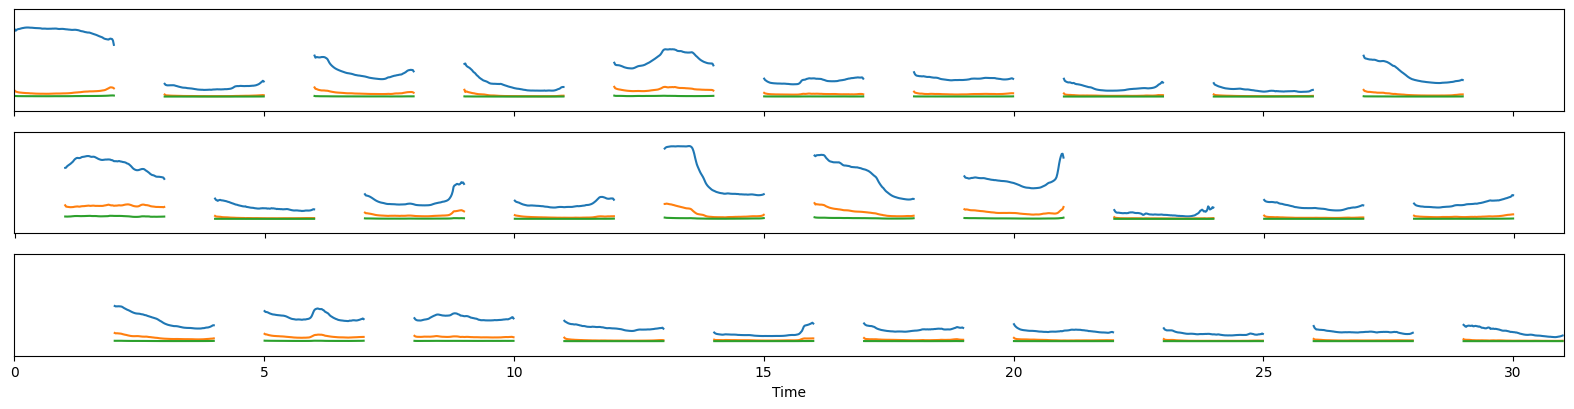

In [5]:
audio_file = next(cow_audio.test())
inference_1=Inference(model,duration=2,step=1)(audio_file)
inference_1

Protocol My_datasets_specified.SpeakerDiarization.Detection does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


Output()

   -  50.00% of all chunks contain no speech at all.
   -  53.45% contain 1 speaker or less
   -  75.86% contain 2 speakers or less
   - 100.00% contain 3 speakers or less
Setting `max_speakers_per_chunk` to 3. You can override this value (or avoid this estimation step) by passing `max_speakers_per_chunk=3` to the task constructor.


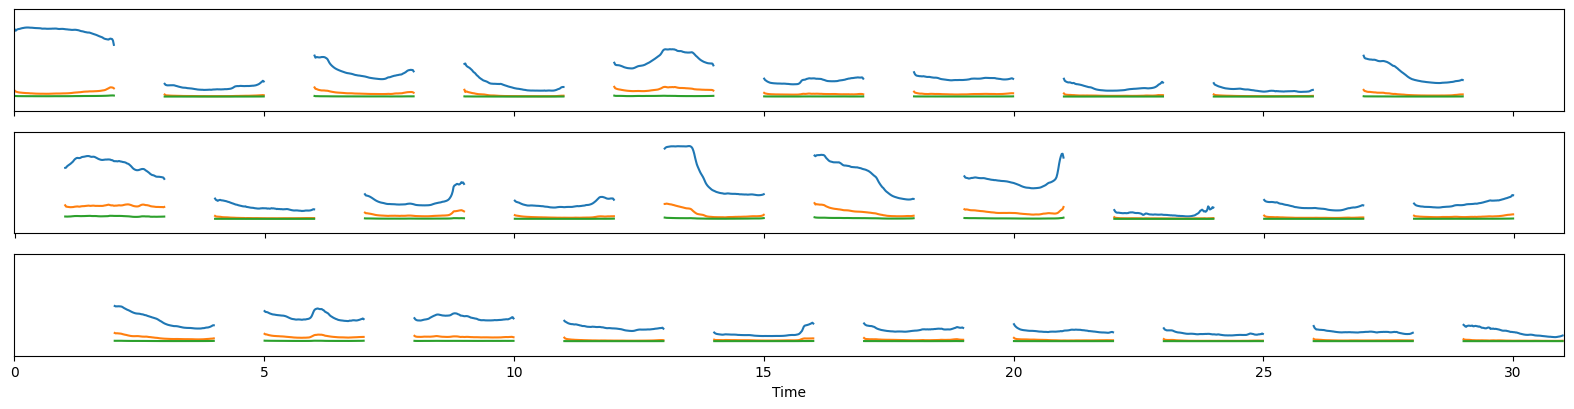

In [6]:
task = MLS_T(
    cow_audio, duration=2.0, batch_size=32,
    #classes= ["rumination","hoofbeat","breath"]
    )
model.task = task
model.specifications
inference_2=Inference(model,duration=2,step=1)(audio_file)
inference_2

In [7]:
output_directory = os.path.join('/mnt/', 'e', 'Files', 'Acoustic_Data', 'Datasets_specified')
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=5, default_root_dir=output_directory)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params | In sizes      | Out sizes                                  
---------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | [1, 1, 32000] | [1, 60, 115]                               
1 | lstm              | LSTM             | 1.4 M  | [1, 115, 60]  | [[1, 115, 256], [[8, 1, 128], [

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


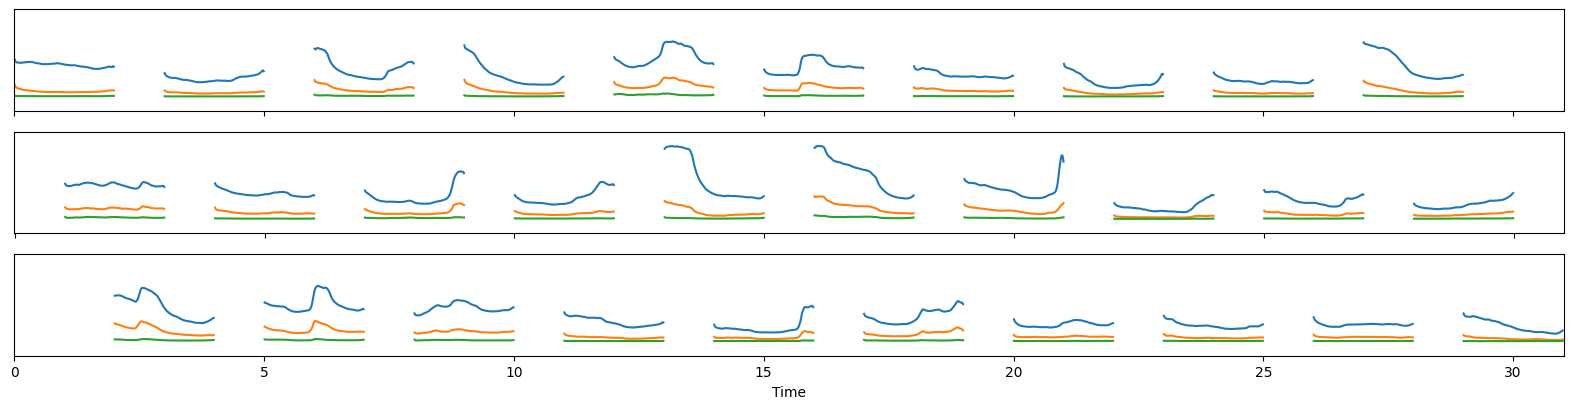

In [8]:
inference_3=Inference(model,duration=2,step=1)(audio_file)
inference_3

In [9]:
#load pipeline 
pipeline = MLS_P(segmentation=model)
initial_params = {
    "thresholds": {
        "rumination": {"onset": 0.3, "offset": 0.2, "min_duration_on": 0, "min_duration_off": 0.00},
        "breath": {"onset": 0.1, "offset": 0.05, "min_duration_on": 0, "min_duration_off": 0.0},
        "hoofbeat": {"onset": 0.3, "offset": 0.2, "min_duration_on":00, "min_duration_off": 0.00},
        #"grazing": {"onset": 0.8, "offset": 0.6, "min_duration_on": 0.005, "min_duration_off": 0.005},
        #"gulp": {"onset": 0.8, "offset": 0.6, "min_duration_on": 0.005, "min_duration_off": 0.005},
    }
}
segmentation = pipeline.instantiate(initial_params)(audio_file)
segmentation

ValueError: parameter 'rumination' does not exist